In [8]:
import os
from dotenv import load_dotenv

load_dotenv()

from google import genai
image_model = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

In [9]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from langchain_text_splitters import RecursiveCharacterTextSplitter

options = PdfPipelineOptions()
options.generate_page_images = True
options.generate_picture_images = True
format_option = {InputFormat.PDF: PdfFormatOption(pipeline_options=options)}
converter = DocumentConverter(format_options=format_option)

In [10]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=200,
    separators=["\n## ", "\n### ", "\n#### ", "\n\n", "\n", " ", ""],
)

In [11]:
result = converter.convert("./test2.pdf")

[INFO] 2026-01-04 18:10:35,297 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-04 18:10:35,302 [RapidOCR] download_file.py:60: File exists and is valid: /home/dinhdat201fb/miniconda3/envs/notebook/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2026-01-04 18:10:35,303 [RapidOCR] main.py:53: Using /home/dinhdat201fb/miniconda3/envs/notebook/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx


[INFO] 2026-01-04 18:10:35,359 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-04 18:10:35,361 [RapidOCR] download_file.py:60: File exists and is valid: /home/dinhdat201fb/miniconda3/envs/notebook/lib/python3.12/site-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-04 18:10:35,361 [RapidOCR] main.py:53: Using /home/dinhdat201fb/miniconda3/envs/notebook/lib/python3.12/site-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2026-01-04 18:10:35,389 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2026-01-04 18:10:35,398 [RapidOCR] download_file.py:60: File exists and is valid: /home/dinhdat201fb/miniconda3/envs/notebook/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_rec_infer.onnx
[INFO] 2026-01-04 18:10:35,399 [RapidOCR] main.py:53: Using /home/dinhdat201fb/miniconda3/envs/notebook/lib/python3.12/site-packages/rapidocr/models/ch_PP-OCRv4_rec_infer.onnx


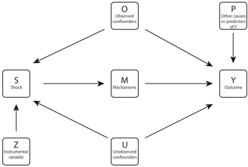

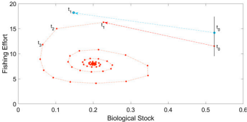

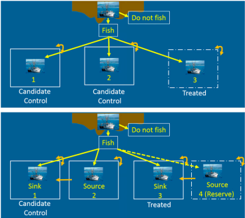

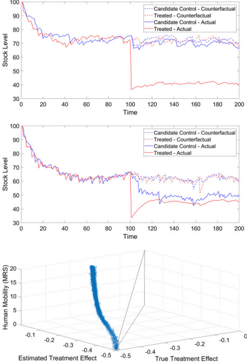

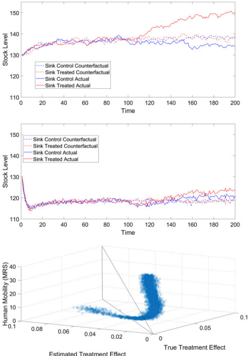

In [12]:
from IPython.display import display
from PIL import ImageOps
from pix2tex.cli import LatexOCR
model = LatexOCR()

for item, _ in result.document.iterate_items():
    label = item.__class__.__name__

    prov = item.prov[0]
    page_no = prov.page_no if item.prov else 1
    page = result.pages[page_no - 1]

    if label == "PictureItem":
        img = item.get_image(result)
        display(img)
    
    elif label == "FormulaItem":
        page_img = page.get_image()
        img_w, img_h = page_img.size

        bbox = prov.bbox
        crop_box = (
            int(bbox.l),
            int(img_h - bbox.t),
            int(bbox.r),
            int(img_h - bbox.b),
        )
        formula_img = page_img.crop(crop_box)
        formula_img = ImageOps.expand(formula_img, border=10, fill="white")

        latex = model(formula_img)
        print("LaTeX:", latex)
        print("Origi:", item.orig)

In [ ]:
context_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1200, 
    chunk_overlap=0,
    separators=["\n## ", "\n### ", "\n\n", "\n", ". "]
)

accumulated_text = ""
enriched_md_parts = []

for item, _ in doc.iterate_items():
    label = item.__class__.__name__

    if label == "SectionHeaderItem":
        header_text = f"\n## {item.text.strip()}"
        enriched_md_parts.append(header_text)
        accumulated_text += header_text + "\n"

    elif label == "TableItem":
        table_md = item.export_to_markdown()
        enriched_md_parts.append(f"\n{table_md}\n")
        accumulated_text += f"\n[Dữ liệu bảng]:\n{table_md}\n"
        print(f"Đã trích xuất bảng tại Trang {item.prov[0].page_no}")

    elif label == "TextItem" or (hasattr(item, "text") and item.text and label not in ["PictureItem", "FormulaItem"]):
        text_content = item.text.strip()
        accumulated_text += text_content + "\n\n"
        enriched_md_parts.append(text_content)
    
    elif label == "PictureItem":
        page_no = item.prov[0].page_no
        page = result.pages[page_no - 1]
        img_crop = page.get_image(cropbox=item.prov[0].bbox)
        
        if img_crop:
            tail_text = accumulated_text[-2000:] if len(accumulated_text) > 2000 else accumulated_text
            relevant_chunks = context_splitter.split_text(tail_text)
            smart_context = relevant_chunks[-1] if relevant_chunks else ""
            
            caption = get_gemini_caption(img_crop, smart_context)
            image_md = f"\n\n> **[Mô tả hình ảnh: {caption}]**\n\n"
            enriched_md_parts.append(image_md)
            accumulated_text += f"[Mô tả ảnh: {caption}]\n\n"            
            print(f"Đã caption ảnh Trang {page_no}")

    elif label == "FormulaItem":
        page_no = item.prov[0].page_no
        page = result.pages[page_no - 1]
        formula_crop = page.get_image(cropbox=item.prov[0].bbox)
        
        if formula_crop:
            latex_prompt = "Chuyển công thức toán học này sang mã LaTeX. Chỉ trả về mã LaTeX trong cặp $$, không giải thích."
            latex_formula = get_gemini_caption(formula_crop, latex_prompt)
            
            enriched_md_parts.append(f"\n{latex_formula}\n")
            accumulated_text += f" {latex_formula} "
            print(f"Đã giải mã LaTeX Trang {page_no}")
    

full_enriched_md = ""
for part in enriched_md_parts:
    if "[Hình ảnh:" in part:
        full_enriched_md += "\n" + part + "\n\n"
    else:
        full_enriched_md += part + "\n\n"

final_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=250,
    separators=["\n## ", "\n### ", "\n\n", "\n", ". "]
)
final_docs = final_splitter.create_documents([full_enriched_md])

Caption cho ảnh tại trang 1 -> The Springer logo, featuring a stylized chess knight icon alongside the publisher's name 'Springer'.
Caption cho ảnh tại trang 3 -> The Springer logo, featuring a stylized chess knight icon alongside the publisher's name 'Springer'.
Caption cho ảnh tại trang 17 -> The 'Check for updates' icon, a digital feature enabling access to current information or revisions pertaining to the publication.
Caption cho ảnh tại trang 20 -> Graphical user interface element labeled 'Check for updates', featuring a bookmark icon, for initiating a system or content revision verification.
Đã giải mã công thức tại Trang 25 -> Page 12 of the document, presenting the definitions and mathematical formulations for Average Treatment Effect (ATE), Average Treatment Effect on the Treated (ATT), Conditional Average Treatment Effect (CATE), and Individual Treatment Effect (ITE) within the context of causal inference.
Đã giải mã công thức tại Trang 25 -> Page 12 from L. Yao et al. prese

KeyboardInterrupt: 

In [ ]:
for i, doc in enumerate(final_docs[:20]):
    if "[Hình ảnh:" in doc.page_content:
        print(f"--- Chunk {i} ---")
        idx = doc.page_content.find("[Hình ảnh:")
        context_before = doc.page_content[max(0, idx-200):idx]
        print(f"Context trước ảnh: {context_before}...")
        print(f"--- Kết thúc Chunk ---\n")